In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [10]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [8]:
#############################
### Import Synthetic Data ###
#############################

#PARSEC
filepath2 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat' 
logiso = ascii.read(filepath2, format='basic', delimiter='\s')
logiso = Table(logiso)

#BaSTI
basti = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_monarch.dat')
tbasti = Table.from_pandas(basti)

#DR 16 with distances in DIST column
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&(lmcdr16['LOGG']<2.0)&\
                (lmcdr16['M_H_ERR']>-90.0))
clndr16 =lmcdr16[clnr]

In [9]:
###############################
### PARSEC and BaSTI Models ###
###############################

'''
x1: logT
x2: K
x3: feh
x4: logg
'''

def modelparsec(x1,x2,x3,x4):
    p = [4.52271170e+02,-2.45756963e+02,1.23004992e+00,-8.43079619e-01,1.50107300e+01,5.55614699e-01,2.33494763e-01,-6.40147708e+00,-6.73945112e-01,3.53816153e+01,1.33852966e-01,9.73455106e-01]
    out = p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*x1*x2+p[6]*x1*x3+p[7]*x1*x4+p[8]*x2*x4+p[9]*x1**2+p[10]*x2**2+p[11]*x4**2 
    return out

def modelbasti(x1,x2,x3,x4):
    p = [2.41534615e+02,-1.22186841e+02,3.49153817e+01,4.17303479e+01,4.94434163e-01,-1.74311571e+01,-2.20365241e+01,-1.73752917e+00,-3.66005605e-01,2.91163491e+00,2.32750310e+00,1.70609136e+01,7.76054149e-02,5.40336479e-01]
    out = p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+p[7]*np.multiply(x1,x4)+p[8]*np.multiply(x2,x4)+p[9]*np.multiply(x1**2,x3)+p[10]*np.multiply(x1**2,x2)+p[11]*(x1**2)+p[12]*(x2**2)+p[13]*(x4**2)
    return out
    

In [27]:
#######################
### Age Calculation ###
#######################

absK = absmag(clndr16['K'],clndr16['DIST'],False)-clndr16['AK_TARG']

p_age = modelparsec(np.log10(clndr16['TEFF']),absK,clndr16['FE_H'],clndr16['LOGG'])
b_age = modelbasti(np.log10(clndr16['TEFF']),absK,clndr16['FE_H'],clndr16['LOGG'])

#Synthetic data residuals
pFE_H = np.log10(logiso['Zini']/0.02)
p_res = modelparsec(logiso['logTe'],logiso['Ksmag'],pFE_H,logiso['logg']) - logiso['logAge']
b_res = modelbasti(tbasti['LOGT'],tbasti['KMAG'],tbasti['FEH'],tbasti['LOGG']) - tbasti['LOGAGE']

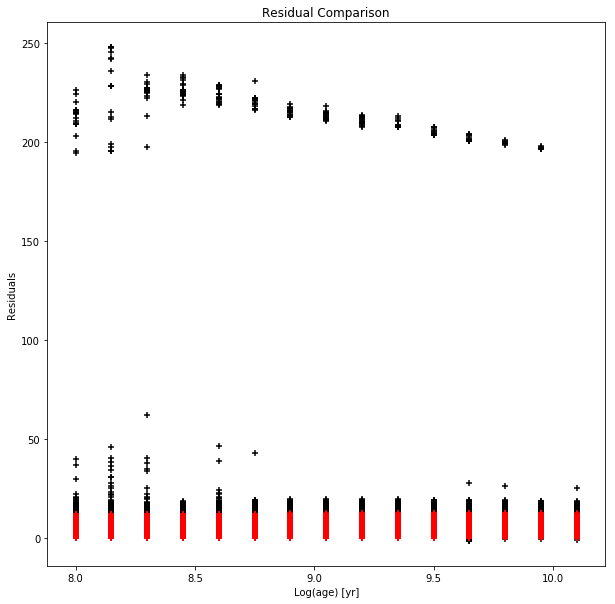

In [37]:
plt.figure(figsize=[10,10])
plt.scatter(logiso['logAge'],p_res,c='k',marker='+',label='PARSEC Residuals')
plt.scatter(tbasti['LOGAGE'],b_res,c='r',marker='+',label='BaSTI Residuals')
plt.ylabel(r'Residuals')
plt.xlabel(r'Log(age) [yr]')
plt.title(r'Residual Comparison')
#plt.savefig('pres_bres.pdf',bbox_inches='tight')
plt.show()

In [39]:
max(p_res)

248.11105630878583

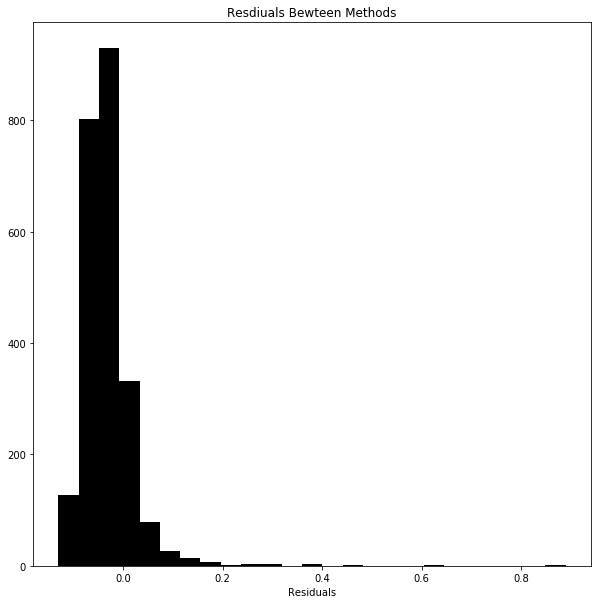

0.023549995047909


In [38]:
#################################
### Difference Between Models ###
#################################

plt.figure(figsize=[10,10])
plt.hist(p_age-b_age,color='k',bins=25)
#plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
#plt.ylim(7,13)
plt.xlabel(r'Residuals')
plt.title(r'Resdiuals Bewteen Methods')
plt.savefig('res_2_methods.pdf',bbox_inches='tight')
plt.show()
print(mad(p_age-b_age))

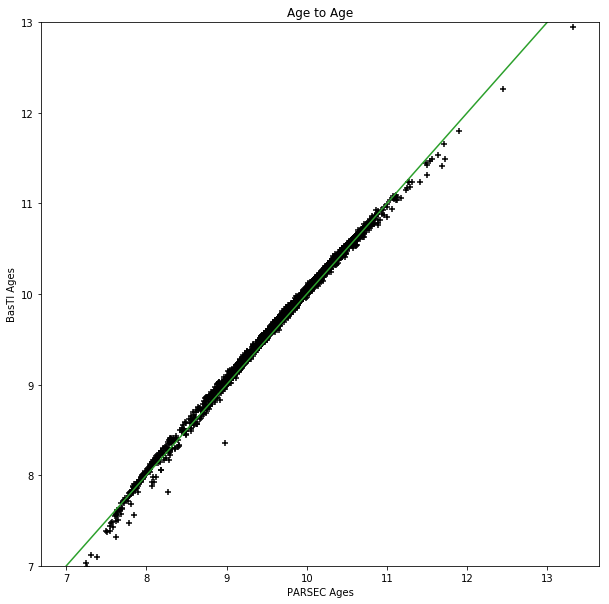

In [19]:
#################################
### Compare models Age to Age ###
#################################

plt.figure(figsize=[10,10])
plt.scatter(p_age,b_age,c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlabel(r'PARSEC Ages')
plt.ylabel(r'BasTI Ages')
plt.title(r'Age to Age')
plt.savefig('page_bage.pdf',bbox_inches='tight')
plt.show()

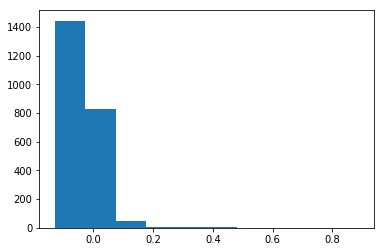